# Sports Analytics Final Project (Group 4)

https://blogs.fangraphs.com/the-southpaw-advantage/

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
atbats = pd.read_csv("atbats.csv")
games = pd.read_csv('games.csv')
pitches = pd.read_csv('pitches.csv')

In [3]:
player_list = pd.read_csv('player_names.csv')

## Filtering for 2018 data just for initial analysis:

In [4]:
atbats.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,top
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,True
1,2015000002,518792,Double,201500001,1,1,0,L,452657,L,True
2,2015000003,407812,Single,201500001,1,1,0,L,452657,R,True
3,2015000004,425509,Strikeout,201500001,1,2,0,L,452657,R,True
4,2015000005,571431,Strikeout,201500001,1,3,0,L,452657,L,True


In [5]:
atbats['year'] = atbats['ab_id']//1e6

In [6]:
atbats_2018 = atbats[atbats['year']==2018]
atbats_2018.to_csv('atbats_2018')

## 2018 Data: 

In [7]:
atbats_2018 = pd.read_csv('atbats_2018')

In [8]:
event_dict = {'Single': '1B','Double': '2B','Triple': '3B','Home Run': 'HR','Walk': 'BB',
            'Intent Walk': 'IBB','Hit By Pitch': 'HBP','Strikeout': 'K','Sac Fly': 'SF',
            'Grounded Into DP': 'GIDP','Groundout': 'GO','Lineout': 'LO','Pop Out': 'PO',
            'Flyout': 'FO','Fielders Choice': 'FC','Sac Bunt': 'SAC','Double Play': 'DP',
            'Triple Play': 'TP','Batter Interference': 'BI','Fan interference': 'FI',
            'Catcher Interference': 'CI','Field Error': 'ROE','Bunt Groundout': 'BGO',
            'Bunt Lineout': 'BLO','Bunt Pop Out': 'BPO','Fielders Choice Out': 'FCO',
            'Forceout': 'FORCE','Sacrifice Bunt DP': 'SBDP','Strikeout - DP': 'KDP',
            'Runner Out': 'RO','Sac Fly DP': 'SFDP'
           }

In [9]:
atbats_2018['event'] = atbats_2018['event'].apply(lambda x: event_dict[x]) 
eventcol = atbats_2018['event']
atbats_2018 = pd.get_dummies(atbats_2018, columns=['event'], prefix='')
atbats_2018['event'] = eventcol

atbats_2018['_H'] = atbats_2018[['_1B', '_2B', '_3B', '_HR']].sum(axis=1) #TOTAL HITS
atbats_2018['_TB'] = atbats_2018['_1B'] + 2*atbats_2018['_2B'] + 3*atbats_2018['_3B'] + 4*atbats_2018['_HR'] #TOTAL BASES
atbats_2018['_K'] = atbats_2018['_K'] + atbats_2018['_KDP'] #TOTAL STRIKEOUTS
atbats_2018['_BB'] = atbats_2018['_BB'] + atbats_2018['_IBB'] #WALKS AND INTENTIONAL WALKS
atbats_2018['_AB'] = 1 - atbats_2018[['_CI', '_SAC', '_BB', 
                            '_HBP', '_RO', '_SF']].sum(axis=1) #AT BATS
atbats_2018['_PA'] = 1 - atbats_2018['_RO'] #PLATE APPEARANCE

atbats_2018['_outs'] = atbats_2018['o'] - atbats_2018.groupby(['g_id', 
                                                'inning', 
                                                'top'])['o'].shift(1).fillna(0) #
atbats_2018['IP'] = atbats_2018.groupby('pitcher_id')['_outs'].transform(pd.Series.cumsum) / 3

In [10]:
atbats_2018.columns

Index(['Unnamed: 0', 'ab_id', 'batter_id', 'g_id', 'inning', 'o', 'p_score',
       'p_throws', 'pitcher_id', 'stand', 'top', 'year', '_1B', '_2B', '_3B',
       '_BB', '_BGO', '_BI', '_BLO', '_BPO', '_CI', '_DP', '_FC', '_FCO',
       '_FO', '_FORCE', '_GIDP', '_GO', '_HBP', '_HR', '_IBB', '_K', '_KDP',
       '_LO', '_PO', '_RO', '_ROE', '_SAC', '_SBDP', '_SF', '_SFDP', '_TP',
       'event', '_H', '_TB', '_AB', '_PA', '_outs', 'IP'],
      dtype='object')

### Pitchers ranked by batting stats:

In [11]:
atbats_2018.head()

,Unnamed: 0,ab_id,batter_id,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,_SF,_SFDP,_TP,event,_H,_TB,_AB,_PA,_outs,IP
0,554815,2018000001,446359,201800001,1,1,0,R,608665,R,...,0,0,0,K,0,0,1,1,1.0,0.333333
1,554816,2018000002,545361,201800001,1,2,0,R,608665,R,...,0,0,0,GO,0,0,1,1,1.0,0.666667
2,554817,2018000003,457708,201800001,1,3,0,R,608665,R,...,0,0,0,PO,0,0,1,1,1.0,1.000000
3,554818,2018000004,459964,201800001,1,0,0,R,572070,L,...,0,0,0,1B,1,1,1,1,0.0,0.000000
4,554819,2018000005,543760,201800001,1,0,0,R,572070,R,...,0,0,0,1B,1,1,1,1,0.0,0.000000


In [12]:
lefty_ids = atbats_2018[atbats_2018.p_throws=='L']['pitcher_id'].unique()
righty_ids = atbats_2018[atbats_2018.p_throws=='R']['pitcher_id'].unique()

In [13]:
min_IP = atbats_2018.groupby('pitcher_id')['IP'].max() > 50
#we want a boolean series to filter out only pitchers who have thrown at least 25 innings pitched 

In [14]:
pitchers_list = player_list[player_list['id'].isin(atbats_2018.pitcher_id)]
pitchers_list.set_index('id',inplace=True)

In [15]:
len(atbats_2018.pitcher_id.unique()) #we have 799 unique pitchers

799

In [16]:
handedness = atbats_2018.groupby('pitcher_id')[['p_throws','pitcher_id']].tail(n=1).set_index('pitcher_id')

In [17]:
pitchers_list = pitchers_list.join(handedness)

### Batting Average Against

In [18]:
pitcher_avgs = atbats_2018.groupby('pitcher_id').apply(lambda x: x['_H'].sum()/x['_AB'].sum())
pitcher_avgs = pd.merge(pitchers_list, pd.DataFrame(pitcher_avgs, columns=['BAA']), left_index=True, right_index=True)

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in longlong_scalars
  """Entry point for launching an IPython kernel.


In [19]:
pitcher_avgs[min_IP].sort_values('BAA').head(15)

#among pitchers with 25 IP, there are our top 15 batters in terms of BAA
#corroborated against 2018 stats, blake snell .178 and scherzer .188

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,first_name,last_name,p_throws,BAA
600917,Jose,Leclerc,R,0.125654
623352,Josh,Hader,L,0.132353
547973,Aroldis,Chapman,L,0.135593
518886,Craig,Kimbrel,R,0.145540
606625,Reyes,Moronta,R,0.153846
622554,Seranthony,Dominguez,R,0.156863
493603,Adam,Ottavino,R,0.157692
595014,Blake,Treinen,R,0.158076
621242,Edwin,Diaz,R,0.159533
543521,Collin,McHugh,R,0.176471


In [20]:
LR_aggregate = pd.DataFrame({'L':pitcher_avgs.loc[lefty_ids][min_IP].mean(),'R':pitcher_avgs.loc[righty_ids][min_IP].mean()})
LR_aggregate

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,L,R
BAA,0.242697,0.239857


## K/9 Innings:

In [21]:
pitcher_K9 = atbats_2018.groupby('pitcher_id').apply(lambda x: x['_K'].sum()/(x['IP'].max()/9))
pitcher_K9 = pd.merge(pitchers_list, pd.DataFrame(pitcher_K9, columns=['K9']), left_index=True, right_index=True)
pitcher_K9[min_IP].sort_values('K9', ascending=False).head(15)

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,first_name,last_name,p_throws,K9
547973,Aroldis,Chapman,L,16.305195
623352,Josh,Hader,L,15.823770
476454,Dellin,Betances,R,15.525000
621242,Edwin,Diaz,R,15.218182
608349,Corey,Knebel,R,14.313253
598264,Matt,Barnes,R,14.010811
518886,Craig,Kimbrel,R,13.860963
519242,Chris,Sale,L,13.500000
502748,Brad,Peacock,R,13.292308
543272,Brad,Hand,L,13.250000


In [22]:
LR_aggregate = pd.concat([LR_aggregate, pd.DataFrame({'L':pitcher_K9.loc[lefty_ids][min_IP].mean(),'R':pitcher_K9.loc[righty_ids][min_IP].mean()})]) 
LR_aggregate

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,L,R
BAA,0.242697,0.239857
K9,8.677162,8.713415


## Fielding Independent Pitching

In [23]:
pitcher_FIP = atbats_2018.groupby('pitcher_id').apply(lambda x: (13*x['_HR'].sum()+3*x['_BB'].sum()+x['_HBP'].sum()-2.0*x['_K'].sum())/x['IP'].max()+3.22)
pitcher_FIP = pd.merge(pitchers_list, pd.DataFrame(pitcher_FIP, columns=['FIP']), left_index=True, right_index=True)
pitcher_FIP[min_IP].sort_values('FIP', ascending=True).head(15)

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.
C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,first_name,last_name,p_throws,FIP
621242,Edwin,Diaz,R,1.501818
595014,Blake,Treinen,R,1.850705
519242,Chris,Sale,L,1.859241
600917,Jose,Leclerc,R,1.884740
547973,Aroldis,Chapman,L,1.953766
594798,Jacob,deGrom,R,1.998802
519293,Will,Smith,L,2.125660
489334,Craig,Stammen,R,2.169367
623352,Josh,Hader,L,2.260984
621237,Jose,Alvarado,L,2.298125


In [24]:
LR_aggregate = pd.concat([LR_aggregate, pd.DataFrame({'L':pitcher_FIP.loc[lefty_ids][min_IP].mean(),'R':pitcher_FIP.loc[righty_ids][min_IP].mean()})]) 
LR_aggregate

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,L,R
BAA,0.242697,0.239857
K9,8.677162,8.713415
FIP,3.904079,3.985036


## Walks and Hits per Innings Pitched (WHIP)

In [25]:
pitcher_WHIP = atbats_2018.groupby('pitcher_id').apply(lambda x: (x['_BB'].sum()+x['_H'].sum())/x['IP'].max())
pitcher_WHIP = pd.merge(pitchers_list, pd.DataFrame(pitcher_WHIP, columns=['WHIP']), left_index=True, right_index=True)
pitcher_WHIP[min_IP].sort_values('WHIP', ascending=True).head(15)

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


,first_name,last_name,p_throws,WHIP
621242,Edwin,Diaz,R,0.790909
623352,Josh,Hader,L,0.811475
595014,Blake,Treinen,R,0.834025
600917,Jose,Leclerc,R,0.849711
519242,Chris,Sale,L,0.860759
434378,Justin,Verlander,R,0.901869
453286,Max,Scherzer,R,0.910876
594798,Jacob,deGrom,R,0.912442
543521,Collin,McHugh,R,0.912442
489446,Kirby,Yates,R,0.920635


In [26]:
LR_aggregate = pd.concat([LR_aggregate, pd.DataFrame({'L':pitcher_WHIP.loc[lefty_ids][min_IP].mean(),'R':pitcher_WHIP.loc[righty_ids][min_IP].mean()})]) 
LR_aggregate

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,L,R
BAA,0.242697,0.239857
K9,8.677162,8.713415
FIP,3.904079,3.985036
WHIP,1.285686,1.260045


Can we draw any conclusions about the performance of left and right handers this season? Well, not exactly given that they are fairly similar - it would appear that on an aggregate level, LHPs and RHPs are able to limit batters to the same number of hits and runs while striking them out at a similar rate. 

## Exploring the Platoon Advantage:

## Pitching Data:

### Characterizing pitch quality between left and right handed batters

Glossary: https://fastballs.wordpress.com/2007/08/02/glossary-of-the-gameday-pitch-fields/

In [27]:
pitches_2018 = pitches[pitches['ab_id']//1e6 == 2018]

In [28]:
pitches_2018.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 724444 entries, 2142710 to 2867153
Data columns (total 40 columns):
px                 718322 non-null float64
pz                 718322 non-null float64
start_speed        718334 non-null float64
end_speed          718334 non-null float64
spin_rate          718322 non-null float64
spin_dir           718322 non-null float64
break_angle        718322 non-null float64
break_length       718322 non-null float64
break_y            718322 non-null float64
ax                 718322 non-null float64
ay                 718322 non-null float64
az                 718322 non-null float64
sz_bot             723353 non-null float64
sz_top             723353 non-null float64
type_confidence    718322 non-null float64
vx0                718322 non-null float64
vy0                718322 non-null float64
vz0                718322 non-null float64
x                  724444 non-null float64
x0                 718322 non-null float64
y                  724

In [29]:
pitches_2018.dropna(inplace=True)

C:\Users\anura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
pitches_2018.head()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,event_num,b_score,ab_id,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
2142710,0.239615,1.848781,93.7,84.5,2632.270,233.718,43.7,5.8,23.7,-19.911162,...,3,0.0,2.018000e+09,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2142711,-0.804047,0.925201,94.0,85.8,2561.181,236.246,42.7,6.1,23.8,-20.043108,...,4,0.0,2.018000e+09,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2142712,0.598637,1.616677,94.7,86.5,2673.854,237.996,44.4,6.0,23.8,-21.510485,...,5,0.0,2.018000e+09,1.0,1.0,0.0,3.0,0.0,0.0,0.0
2142713,1.453223,1.466314,82.3,76.7,959.909,38.861,-8.2,10.8,23.9,4.974062,...,6,0.0,2.018000e+09,1.0,2.0,0.0,4.0,0.0,0.0,0.0
2142714,-0.427914,2.490041,95.4,87.1,2408.148,241.080,40.9,6.1,23.8,-20.172978,...,7,0.0,2.018000e+09,1.0,2.0,0.0,5.0,0.0,0.0,0.0


In [31]:
pitches_2018['pitch_type'].unique()

array(['SI', 'SL', 'FF', 'FC', 'CU', 'CH', 'FT', 'FS', 'KC', 'EP', 'FO',
       'PO', 'SC', 'KN', 'AB'], dtype=object)

In [32]:
relevant_pitches = ['SI', 'SL', 'FF', 'FC', 'CU', 'CH', 'FT', 'FS', 'KC']
pitch_dict = {'SI':'Sinker', 
              'SL':'Slider', 
              'FF':'4-Seam Fastball', 
              'FC':'Cutter', 
              'CU':'Curveball', 
              'CH':'Change-up', 
              'FT':'2-Seam Fastball' , 
              'FS':'Splitter', 
              'KC':'Knuckle Curve'}

In [33]:
pitches_2018 = pitches_2018[pitches_2018['pitch_type'].isin(relevant_pitches)]
pitches_2018['pitch_type'] = pitches_2018['pitch_type'].apply(lambda x: pitch_dict[x])

In [34]:
df = pitches_2018.merge(atbats_2018[['ab_id','pitcher_id']], on='ab_id').join(pitchers_list, on = 'pitcher_id')
pitch_qualities = ['start_speed', 'spin_rate', 'break_angle', 'pfx_x', 'pfx_z', 'pitch_type','p_throws']
df = df[pitch_qualities]
df['pfx_x'] = df.apply(lambda x: -x['pfx_x'] if x['p_throws'] == 'L' else x['pfx_x'], axis=1)

In [35]:
#higher prevalence of left handed pitchers in baseball than in the general population (25% vs 10%)
pitchers_list['p_throws'].value_counts()/len(pitchers_list)

R    0.742178
L    0.257822
Name: p_throws, dtype: float64

In [36]:
df.groupby(['pitch_type','p_throws']).mean()

start_speed    spin_rate  break_angle     pfx_x  \
pitch_type      p_throws                                                    
2-Seam Fastball L           91.016580  2053.397747   -31.032512 -8.443629   
                R           93.039273  2171.105692    34.401718 -8.724895   
4-Seam Fastball L           92.243591  2100.911444   -24.380482 -5.055384   
                R           93.492785  2103.426330    24.265219 -4.707828   
Change-up       L           83.263122  1776.668811   -23.732636 -8.476321   
                R           84.713838  1700.143655    22.879304 -7.957612   
Curveball       L           76.723534  1192.275530     8.535280  4.365374   
                R           79.035691  1268.085825    -9.755467  4.750553   
Cutter          L           87.368854   973.740864     3.047743  0.233648   
                R           89.339412  1052.609924    -5.476308  0.842028   
Knuckle Curve   L           79.618885   862.211572     4.693834  1.984771   
                R           81.286732  1309.628808    -8.510987  3.945319   
Sinker          L           91.329291  2131.582999   -31.851260 -8.779017   
                R           91.745366  2070.284181    31.182606 -9.110671   
Slider          L           83.117205   737.104903     7.544137  2.416350   
                R           84.809335   727.104510    -7.845674  2.423010   
Splitter        L           83.863003  1505.296560   -19.976426 -7.347289   
                R           85.280235  1365.661832    17.949133 -6.347442   

                             pfx_z  
pitch_type      p_throws            
2-Seam Fastball L         5.855799  
                R         6.173368  
4-Seam Fastball L         9.014234  
                R         9.098860  
Change-up       L         4.488098  
                R         3.980337  
Curveball       L        -5.218231  
                R        -4.958307  
Cutter          L         4.766796  
                R         4.977691  
Knuckle Curve   L        -4.154981  
                R        -6.051857  
Sinker          L         5.542114  
                R         4.239377  
Slider          L         1.047404  
                R         1.228757  
Splitter        L         2.950074  
                R         2.857380

In [37]:
#here we calculate the difference in pitch qualities between RHP and LHP (i.e. +ve value indicates RHP throws harder, etc)
df.groupby(['pitch_type','p_throws']).mean().groupby('pitch_type').diff(1).groupby('pitch_type').tail(n=1)

,,start_speed,spin_rate,break_angle,pfx_x,pfx_z
pitch_type,p_throws,,,,,
2-Seam Fastball,R,2.022693,117.707944,65.434230,-0.281265,0.317570
4-Seam Fastball,R,1.249195,2.514886,48.645701,0.347556,0.084626
Change-up,R,1.450717,-76.525156,46.611940,0.518708,-0.507762
Curveball,R,2.312157,75.810295,-18.290747,0.385179,0.259924
Cutter,R,1.970558,78.869061,-8.524051,0.608380,0.210895
Knuckle Curve,R,1.667847,447.417236,-13.204821,1.960548,-1.896876
Sinker,R,0.416074,-61.298817,63.033866,-0.331654,-1.302737
Slider,R,1.692129,-10.000393,-15.389811,0.006660,0.181353
Splitter,R,1.417232,-139.634729,37.925560,0.999848,-0.092694


### T-Testing the Difference 

### Is the Platoon Advantage True? Do LHPs perform better against LHBs than RHBs?

Regression analysis on the basis of at-bats; outcomes measured in terms of hits (1 or 0) or multi-class classification (1B,2B,3B,HR) or expected bases (0-4)

## Plotting strikes and balls

px: the left/right distance, in feet, of the pitch from the middle of the plate as it crossed home plate. The PITCHf/x coordinate system is oriented to the catcher’s/umpire’s perspective, with distances to the right being positive and to the left being negative.

pz: the height of the pitch in feet as it crossed the front of home plate.

type: a one-letter abbreviation for the result of the pitch: B, ball; S, strike (including fouls); X, in play.

In [38]:
df.head()

,start_speed,spin_rate,break_angle,pfx_x,pfx_z,pitch_type,p_throws
0,93.7,2632.270,43.7,-10.721801,7.870604,Sinker,R
1,94.0,2561.181,42.7,-10.647298,7.115135,Sinker,R
2,94.7,2673.854,44.4,-11.206094,7.003230,Sinker,R
3,82.3,959.909,-8.2,3.397188,-4.215796,Slider,R
4,95.4,2408.148,40.9,-10.308374,5.695114,Sinker,R


In [39]:
atbats_2018.columns

Index(['Unnamed: 0', 'ab_id', 'batter_id', 'g_id', 'inning', 'o', 'p_score',
       'p_throws', 'pitcher_id', 'stand', 'top', 'year', '_1B', '_2B', '_3B',
       '_BB', '_BGO', '_BI', '_BLO', '_BPO', '_CI', '_DP', '_FC', '_FCO',
       '_FO', '_FORCE', '_GIDP', '_GO', '_HBP', '_HR', '_IBB', '_K', '_KDP',
       '_LO', '_PO', '_RO', '_ROE', '_SAC', '_SBDP', '_SF', '_SFDP', '_TP',
       'event', '_H', '_TB', '_AB', '_PA', '_outs', 'IP'],
      dtype='object')

In [40]:
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit

### Merging Atbats and Pitches databases to get the relevent variables in one dataframe

In [41]:
Data = pd.merge(atbats_2018,pitches_2018, on = 'ab_id', how = 'left')

In [42]:
Data.dropna(inplace = True)

### Using PCA to test if the dimensions in of the categorical variables can be reduced

In [43]:
Data_num = Data.dtypes[Data.dtypes != 'object']
Data_num = Data[Data_num.index]

In [44]:
Data_num

,Unnamed: 0,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,top,year,...,zone,event_num,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,554815,2018000001,446359,201800001,1,1,0,608665,True,2018,...,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,554815,2018000001,446359,201800001,1,1,0,608665,True,2018,...,13.0,4.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,554815,2018000001,446359,201800001,1,1,0,608665,True,2018,...,9.0,5.0,0.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0
3,554815,2018000001,446359,201800001,1,1,0,608665,True,2018,...,14.0,6.0,0.0,1.0,2.0,0.0,4.0,0.0,0.0,0.0
4,554815,2018000001,446359,201800001,1,1,0,608665,True,2018,...,4.0,7.0,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
718599,740387,2018185573,595879,201802431,9,2,3,623352,False,2018,...,8.0,568.0,1.0,3.0,2.0,2.0,9.0,0.0,0.0,0.0
718600,740388,2018185574,519203,201802431,9,3,3,623352,False,2018,...,13.0,572.0,1.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0
718601,740388,2018185574,519203,201802431,9,3,3,623352,False,2018,...,4.0,577.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0
718602,740388,2018185574,519203,201802431,9,3,3,623352,False,2018,...,13.0,578.0,1.0,1.0,1.0,2.0,3.0,0.0,1.0,0.0


In [45]:
from sklearn import preprocessing
# Get column names first
names = Data_num.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_Data_num = scaler.fit_transform(Data_num)
scaled_Data_num = pd.DataFrame(scaled_Data_num, columns=names)

In [46]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
pca.fit(scaled_Data_num)

PCA(n_components=0.95)

Text(0, 0.5, 'cumulative explained variance')

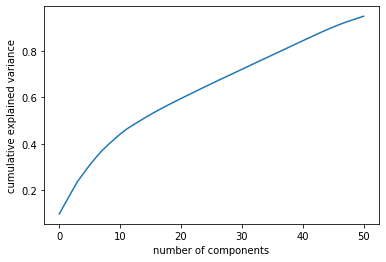

In [47]:
#pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

### As we can see, there is no elbow when we use dummy variables. Hence we need to keep all the variables

In [48]:
Data.columns

Index(['Unnamed: 0', 'ab_id', 'batter_id', 'g_id', 'inning', 'o', 'p_score',
       'p_throws', 'pitcher_id', 'stand', 'top', 'year', '_1B', '_2B', '_3B',
       '_BB', '_BGO', '_BI', '_BLO', '_BPO', '_CI', '_DP', '_FC', '_FCO',
       '_FO', '_FORCE', '_GIDP', '_GO', '_HBP', '_HR', '_IBB', '_K', '_KDP',
       '_LO', '_PO', '_RO', '_ROE', '_SAC', '_SBDP', '_SF', '_SFDP', '_TP',
       'event', '_H', '_TB', '_AB', '_PA', '_outs', 'IP', 'px', 'pz',
       'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle',
       'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot', 'sz_top',
       'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0', 'z0',
       'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'pitch_type',
       'event_num', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num',
       'on_1b', 'on_2b', 'on_3b'],
      dtype='object')

### Creating a logistic regression model and training it on the pitches data

In [49]:
formula = '_H ~ C(pitch_type) + C(stand) + start_speed + end_speed + spin_rate + spin_dir + break_angle + break_length + break_y + ax + ay + az + sz_bot + sz_top + type_confidence + vx0 + vy0 + vz0 + x + x0 + y + y0 + z0 + pfx_x + pfx_z'
model = logit(formula, Data).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.489687
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                     _H   No. Observations:               717188
Model:                          Logit   Df Residuals:                   717156
Method:                           MLE   Df Model:                           31
Date:                Fri, 11 Dec 2020   Pseudo R-squ.:                0.004749
Time:                        16:43:19   Log-Likelihood:            -3.5120e+05
converged:                       True   LL-Null:                   -3.5287e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.0117   4.09e+04   2.86e-

In [50]:
Data['Hit_Prediction'] = model.predict(Data)

In [51]:
Data['Hit_Gained'] = Data['_H'] - Data['Hit_Prediction']
Hit_Gained = Data.groupby('pitcher_id')['Hit_Gained'].sum().to_frame().reset_index()
Hit_Gained_count = Data.groupby('pitcher_id')['Hit_Gained'].count().to_frame().reset_index()

In [52]:
Hit_Gained_count.rename(columns = {'Hit_Gained' : 'Count'}, inplace = True)
Comb = pd.merge(Hit_Gained,Hit_Gained_count, on = 'pitcher_id', how = 'right')

In [53]:
Comb.rename(columns = {'pitcher_id' : 'id'}, inplace = True)

In [54]:
Ranking = pd.merge(player_list,Comb, on = 'id', how = 'right')
Ranking.rename(columns = {'id' : 'pitcher_id'}, inplace = True)
Ranking = Ranking[Ranking['Count'] >= 500]
Ranking['Rank'] = Ranking['Hit_Gained'].rank()
Ranking.sort_values(by = ['Rank'])

,pitcher_id,first_name,last_name,Hit_Gained,Count,Rank
338,468504,Jhoulys,Chacin,-135.669169,3006,1.0
11,527054,Julio,Teheran,-132.750343,2797,2.0
43,453286,Max,Scherzer,-129.220348,3480,3.0
89,493603,Adam,Ottavino,-111.231430,1271,4.0
383,605483,Blake,Snell,-102.981350,2913,5.0
...,...,...,...,...,...,...
83,592332,Kevin,Gausman,100.790934,3004,461.0
664,669456,Shane,Bieber,102.421165,1802,462.0
321,527048,Martin,Perez,102.720871,1404,463.0
311,519043,Matt,Moore,123.035103,1789,464.0


In [55]:
Ranking = pd.merge(atbats_2018[['pitcher_id','p_throws']].drop_duplicates(),Ranking, on = 'pitcher_id', how = 'right')

In [56]:
Ranking.sort_values(by = ['Rank'])

,pitcher_id,p_throws,first_name,last_name,Hit_Gained,Count,Rank
143,468504,R,Jhoulys,Chacin,-135.669169,3006,1.0
87,527054,R,Julio,Teheran,-132.750343,2797,2.0
176,453286,R,Max,Scherzer,-129.220348,3480,3.0
49,493603,R,Adam,Ottavino,-111.231430,1271,4.0
116,605483,L,Blake,Snell,-102.981350,2913,5.0
...,...,...,...,...,...,...,...
252,592332,R,Kevin,Gausman,100.790934,3004,461.0
422,669456,R,Shane,Bieber,102.421165,1802,462.0
322,527048,L,Martin,Perez,102.720871,1404,463.0
202,519043,L,Matt,Moore,123.035103,1789,464.0


In [57]:
Ranking.groupby('p_throws').mean()

,pitcher_id,Hit_Gained,Count,Rank
p_throws,,,,
L,554693.627907,-5.999757,1464.248062,220.294574
R,557087.607143,-1.827638,1379.309524,237.877976


In [58]:
Ranking[Ranking['Count'] >= 663].groupby('p_throws').mean()['Hit_Gained']

p_throws
L   -5.847355
R   -3.306096
Name: Hit_Gained, dtype: float64

In [59]:
Data.groupby('p_throws').mean()['Hit_Gained']
#plt.hist(Data['Hit_Gained'])

p_throws
L   -0.001518
R    0.000604
Name: Hit_Gained, dtype: float64

In [60]:
from scipy import stats

In [61]:
stats.ttest_ind(Data[Data['p_throws'] == 'L']['Hit_Gained'],Data[Data['p_throws'] == 'R']['Hit_Gained'], equal_var = False)

Ttest_indResult(statistic=-2.06269627841003, pvalue=0.03914217524958424)

### The T-test is on the parameter Hit-Gained between left hand and right handed pitches thrown.